# DTU Compute employee statistics
Collected from the webpage

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vedranaa/teaching-notebooks/blob/main/collect_compute_employee_stats.ipynb)


In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
def get_section_url(sect, page=0):
    startpage = 1 + page * 100
    base = "https://www.compute.dtu.dk/english/research/research-sections"
    if sect == 'dynsys':
        return base + f"/dynsys/employees-at-dynsys?fr={startpage}&mr=100"
    else:
        return base + f"/{sect}/employees?fr={startpage}&mr=100"
    
def get_section_namelines(sect, nr_pages=2):
    
    start = ['Name', 'Building and room', 'Ph.', 'E-mail', 'Title']
    end = ['Previous page']

    namelines = []
    for page in range(2):
        req = Request(
            url=get_section_url(sect, page),
            headers={'User-Agent': 'Mozilla/5.0'})
        html = urlopen(req).read()
        soup = BeautifulSoup(html, features="html.parser")
        for script in soup(["script", "style"]):
            script.extract()   

        lines = (line.strip() for line in soup.get_text().splitlines())
        lines = [line for line in lines if line]
        lines = lines[lines.index(start[-4]) + 4 : lines.index(end[0])]
        namelines.extend(lines)
    
    return namelines

def parse_nameline(nameline):
    # We have 4 options, as far as I can see:
    # First LastJob description
    # First LastBld. 303, Room 100Job description
    # First LastBld. 303, Room 100+45 45 45 45 45Job description
    # First LastBld. 303, Room 100Job description+45 45 45 45 45
    job_descriptions = ['Industrial PhD']  # This is the only problematic when parsing

    phone_number_pattern = r'\+[\d\s]*'
    building_pattern = r'Bld\. [\d.]*[A-Z]*, room [\d\.]*(Flyverpladser)*'

    # Remove phone number from end of line, if present
    nameline = re.sub(phone_number_pattern + '$', '', nameline)    
    # Remove middle part consisting of maybe building and maybe phone)
    name_job = re.split(building_pattern + phone_number_pattern, nameline)
    if len(name_job) == 1:
        name_job = re.split(building_pattern, nameline)
    if len(name_job) == 1:
        name_job = re.split(phone_number_pattern, nameline)
    if len(name_job) == 1:
        # Find small letter followed by capital letter without space
        k = re.search(r'[a-z][A-Z]', nameline)
        j = re.search(r'PhD', nameline)  # but exclude pattern 'PhD'
        if k and ((not j) or ((k.start() - 1)!=j.start())) :
            name_job = [nameline[:k.start() + 1], nameline[k.start() + 1:]]
    if len(name_job) == 1:
        # Last resort: search for known job descriptions
        for j in job_descriptions:
            if name_job[0].endswith(j):
                name_job = [name_job[0][:-len(j)], j]
    elif len(name_job)>2:
        name_job = [name_job[0], name_job[-1]]
    return [n.strip() for n in name_job]    


sections = ['algolog', 'cogsys', 'cyber', 'dynsys', 'ese', 'mathematics', 
            'sco', 'software-systems-engineering', 'stat', 'visual-computing']

sectionnamelong = {
    'algolog': 'Algorithms, Logic and Graphs',
    'cogsys': 'Cognitive Systems',
    'cyber': 'Cybersecurity Engineering',
    'dynsys': 'Dynamical Systems',
    'ese': 'Embedded Systems Engineering',
    'mathematics': 'Mathematics',
    'sco': 'Scientific Computing',
    'software-systems-engineering': 'Software Systems Engineering',
    'stat': 'Statistics and Data Analysis',
    'visual-computing': 'Visual Computing'
}

sectionnameshort = {
    'Algorithms, Logic and Graphs': 'AlgoLog',
    'Cognitive Systems': 'CogSys',
    'Cybersecurity Engineering': 'Cyber',
    'Dynamical Systems': 'DynSys',
    'Embedded Systems Engineering': 'EmbSE',
    'Mathematics': 'Math',
    'Scientific Computing': 'SciComp',
    'Software Systems Engineering': 'SoftSE',
    'Statistics and Data Analysis': 'Stat',
    'Visual Computing': 'VisComp',
}

compute_jobs = {
    'Academic assistant': 'Academic Assistant',
    'Academic officer': 'Academic Officer',
    'Administrative Coordinator': 'Administrative Coordinator',
    'Akademisk medarbejder': 'Academic Officer',
    'Assistant Professor': 'Assistant Professor',
    'Assistant Professor (Tenure track)': 'Assistant Professor (Tenure Track)',
    'Assistant Professor (tenure track)': 'Assistant Professor (Tenure Track)',
    'Assistant Professor - Tenure track': 'Assistant Professor (Tenure Track)',
    'Associate Professor': 'Associate Professor',
    'Associate professor': 'Associate Professor',
    'Bachelor': 'Student (Bachelor)',
    'Chief Consultant': 'Chief Consultant',
    'Chief consultant': 'Chief Consultant',
    'Communications Manager': 'Communications Manager',
    'Consultant': 'Consultant',
    'DDSA Education @ Grant Manager': 'DDSA (Education @ Grant Manager)',
    'DDSA Event planner': 'DDSA (Event Planner)',
    'DDSA Funding Coordinator': 'DDSA (Funding Coordinator)',
    'Deputy director, head of section, Professor': 'Professor (Head of Section, Deputy Director)',
    'Emeritur, Associate professor': 'Emeritus (Associate Professor)',
    'Emeritus': 'Emeritus',
    'Emeritus, Professor': 'Emeritus (Professor)',
    'Executive Assistant, DDSA': 'DDSA (Executive Assistant)',
    'External associate professor': 'External (Associate Professor)',
    'External lekturer': 'External (Lecturer)',
    'HR Consultant': 'Consultant (HR)',
    'Head of Section': 'Professor (Head of Section)',
    'Head of Section, Professor': 'Professor (Head of Section)',
    'IT employee': 'IT Employee',
    'IT medarbejder': 'IT Employee',
    'Industrial PhD': 'PhD Student (Industrial)',
    'Industrial Postdoc': 'Postdoc (Industrial)',
    'Industriel postdoc': 'Postdoc (Industrial)',
    'Managing Director': 'DDSA (Managing Director)',
    'Ph.d.-studerende': 'PhD Student',
    'PhD Student': 'PhD Student',
    'PhD student': 'PhD Student',
    'Postdoc': 'Postdoc',
    'Professor': 'Professor',
    'Professor emeritus': 'Emeritus (Professor)',
    'Professor, Head of Section': 'Professor (Head of Section)',
    'Professor, Head of section': 'Professor (Head of Section)',
    'Professor, head of section': 'Professor (Head of Section)',
    'Programme Director': 'Programme Director',
    'Programmer': 'Student (Programmer)',
    'Project Coordinator': 'Project Coordinator',
    'Research Assistant': 'Research Assistant',
    'Researcher': 'Researcher',
    'Senior Academic Officer': 'Senior Academic Officer',
    'Senior Executive Officer': 'Senior Executive Officer',
    'Senior Executive Officer / Center Manager': 'Senior Executive Officer (Center Manager)',
    'Senior Researcher': 'Senior Researcher',
    'Service Designer': 'Service Designer',
    'Software developer': 'Software Developer',
    'Special consultant': 'Special Consultant',
    'Student Assistant': 'Student (Assistant)',
    'Student Programmer': 'Student (Programmer)',
    'Studentermedhjælper': 'Student (Assistant)',
    'Studielektor': 'Associate Professor (Teaching)',
    'Teaching Associate Professor': 'Associate Professor (Teaching)',
    'Team Lead, Innovation & Consulting. Senior Executive Officer': 'Senior Executive Officer (Team Lead, Innovation & Consulting)',
    'Visiting Postdoc': 'External (Postdoc)',
}

In [3]:
#% Scrape names from DTU Compute website
namelinesdict = {}
for section in sections:
    print(f"Getting names for {sectionnamelong[section]}...", end= ' ')
    namelines = get_section_namelines(section)
    namelinesdict[section] = namelines
    print(f"found {len(namelines)} names.")
    
#%% Make dataframe for a whole DTU compute
frames = []
for section in sections:
    n_j = [parse_nameline(nl) for nl in namelinesdict[section]]
    frame = pd.DataFrame(n_j, columns=['Name', 'Title'])
    frame['Section'] = sectionnamelong[section]
    frames.append(frame)
COMPUTE = pd.concat(frames)

# Fix inconsistencies in job titles
COMPUTE['Title'] = COMPUTE['Title'].map(compute_jobs)

# Remove parentheses for short title
COMPUTE['Short title'] = COMPUTE['Title'].str.replace(r'\s*\(.*\)\s*', '', regex=True)

Getting names for Algorithms, Logic and Graphs... found 36 names.
Getting names for Cognitive Systems... found 103 names.
Getting names for Cybersecurity Engineering... found 22 names.
Getting names for Dynamical Systems... found 41 names.
Getting names for Embedded Systems Engineering... found 26 names.
Getting names for Mathematics... found 18 names.
Getting names for Scientific Computing... found 43 names.
Getting names for Software Systems Engineering... found 25 names.
Getting names for Statistics and Data Analysis... found 38 names.
Getting names for Visual Computing... found 67 names.


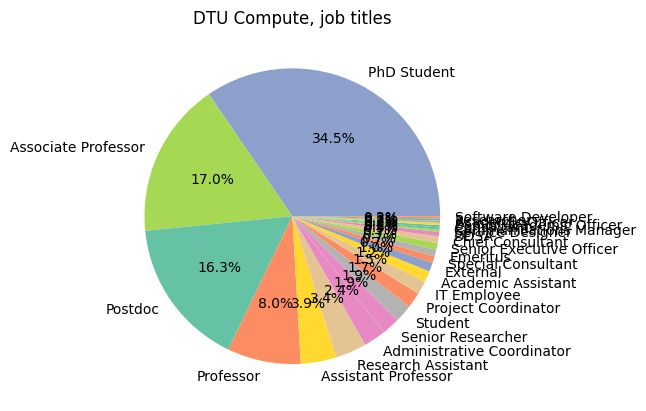

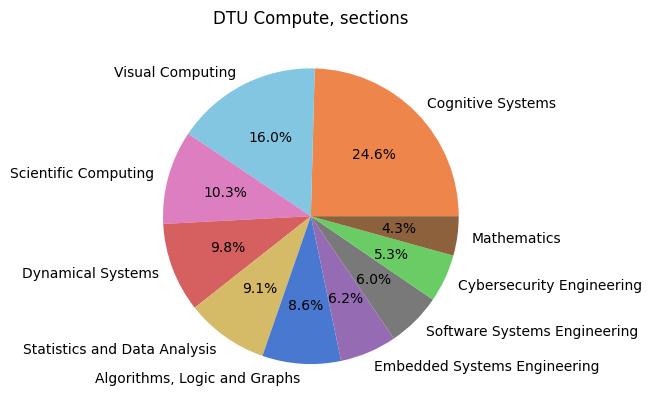

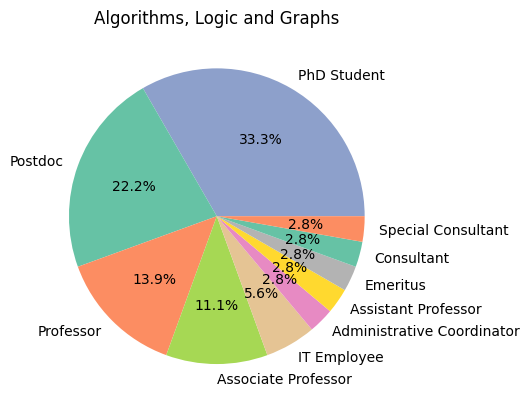

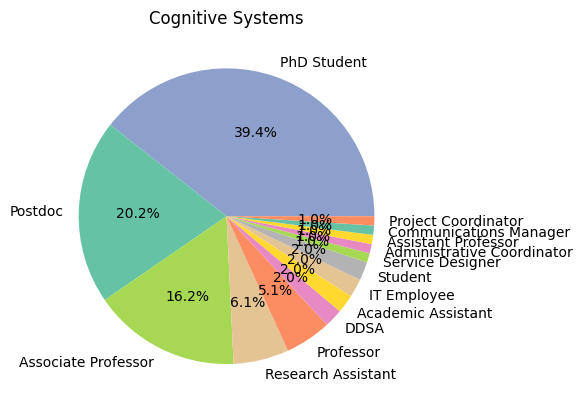

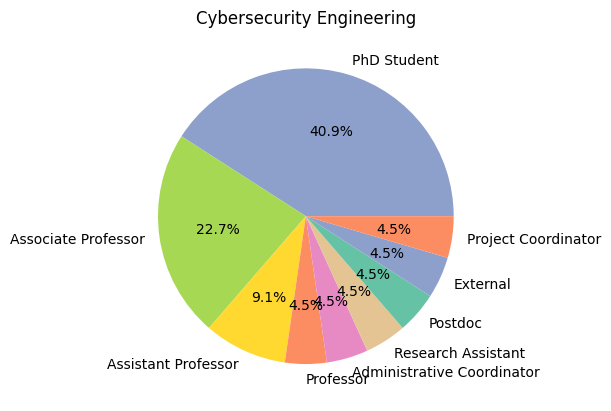

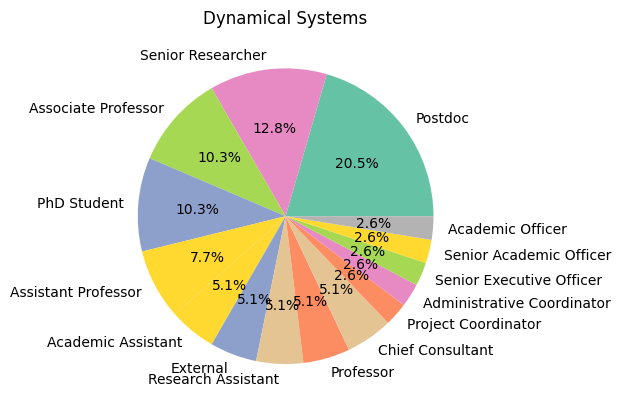

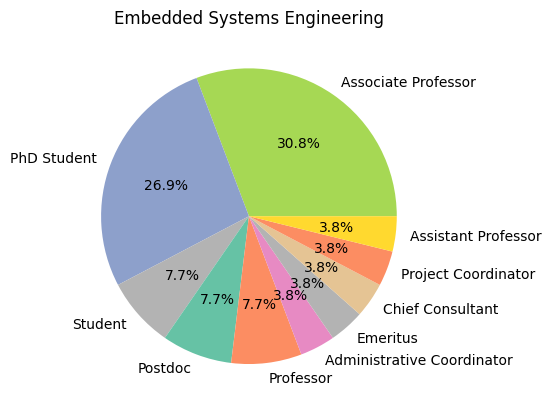

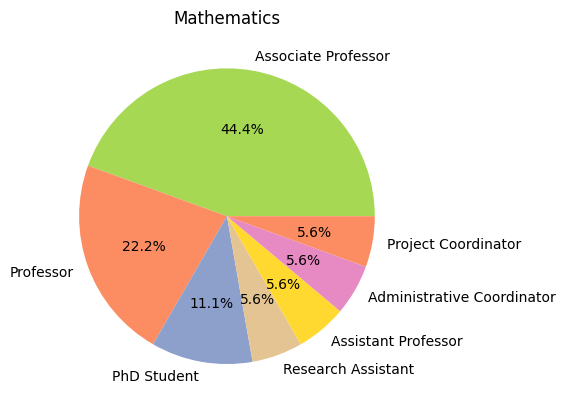

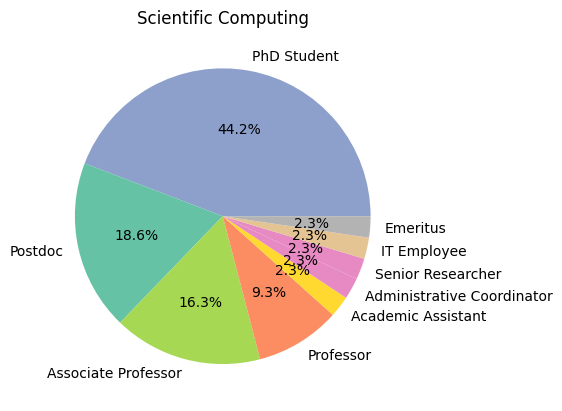

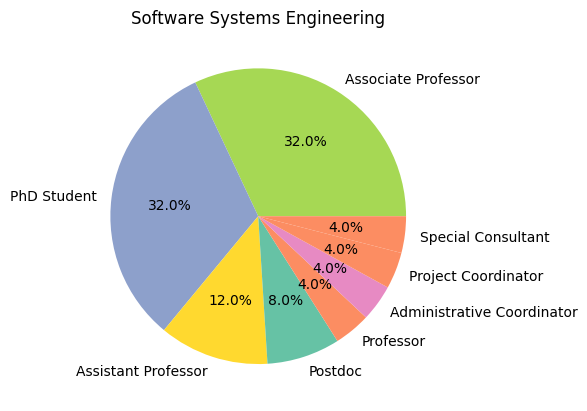

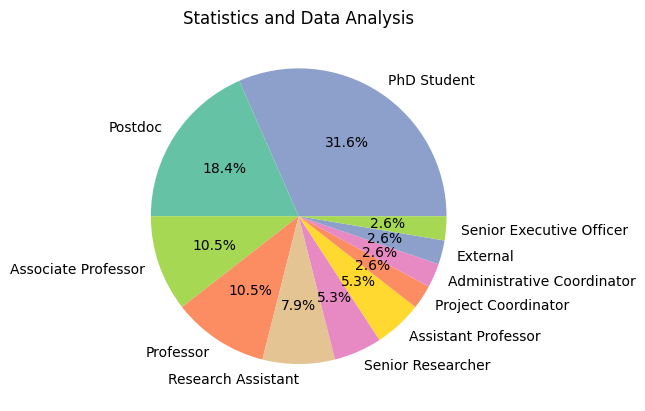

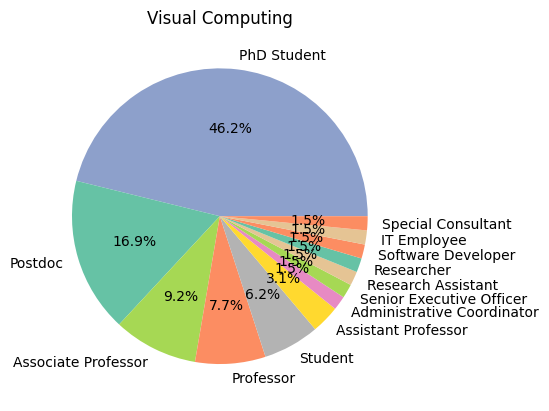

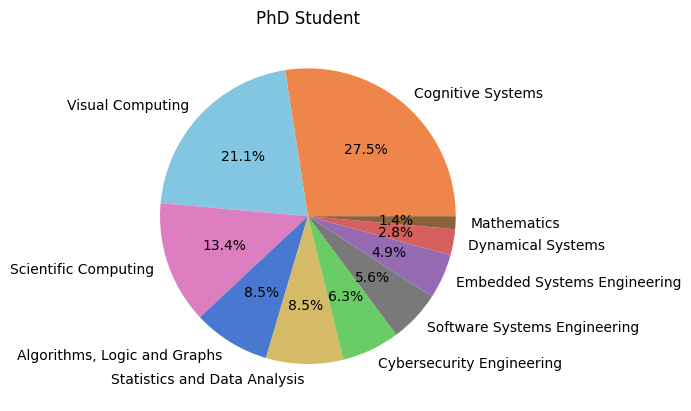

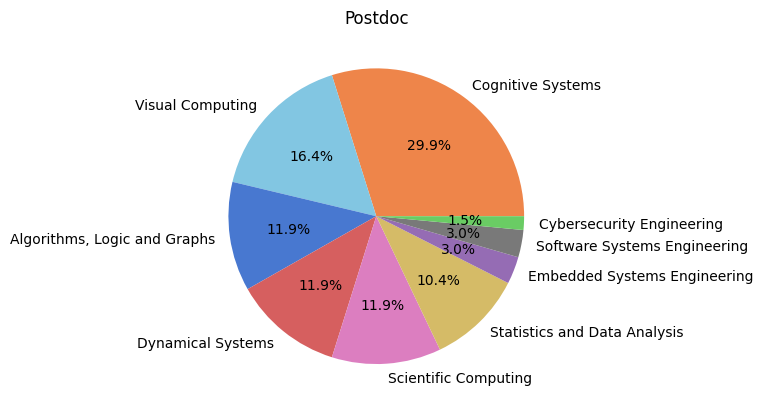

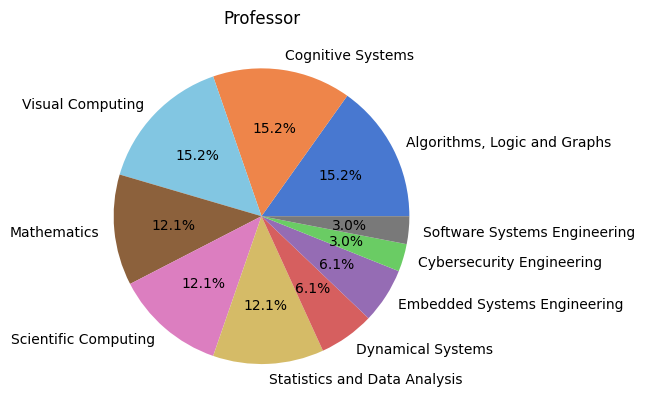

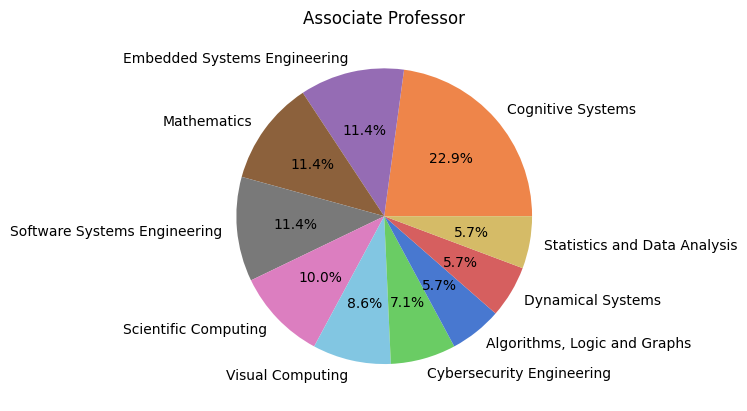

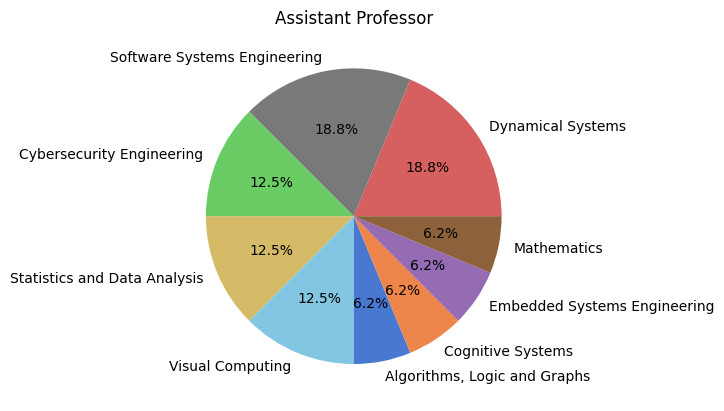

In [4]:
#%% Visualize

jobs = COMPUTE['Short title'].unique()
colors = sns.color_palette("Set2", len(jobs))
colors_jobs = {label: color  for label, color in zip(jobs, colors)}
colors = sns.color_palette("muted", len(sections))
colors_sections = {label: color  for label, color in zip(sectionnamelong.values(), colors)}

counts = COMPUTE['Short title'].value_counts()
counts.plot.pie(autopct='%1.1f%%', ylabel='', colors=[colors_jobs[v] for v in counts.keys()])
plt.title('DTU Compute, job titles')
plt.show()

counts = COMPUTE['Section'].value_counts()
counts.plot.pie(autopct='%1.1f%%', ylabel='', colors=[colors_sections[v] for v in counts.keys()])
plt.title('DTU Compute, sections')
plt.show()

for section in sections:
    this_section = COMPUTE[COMPUTE['Section']==sectionnamelong[section]]
    counts = this_section['Short title'].value_counts()
    counts.plot.pie(autopct='%1.1f%%', ylabel='', colors=[colors_jobs[v] for v in counts.keys()])
    plt.title(sectionnamelong[section])
    plt.show()  

for jobs in ['PhD Student', 'Postdoc', 'Professor', 'Associate Professor', 'Assistant Professor']:
    this_job = COMPUTE[COMPUTE['Short title']==jobs]
    counts = this_job['Section'].value_counts()
    counts.plot.pie(autopct='%1.1f%%', ylabel='', colors= [colors_sections[v] for v in counts.keys()])
    plt.title(jobs)
    plt.show()

In [5]:
#%% Nicely print all employees

COMPUTE['Short Section'] = COMPUTE['Section'].map(sectionnameshort)
SHORTNAMES = COMPUTE[['Name', 'Short title', 'Short Section']]
SHORTNAMES = SHORTNAMES.rename(columns={'Short title': 'Title', 'Short Section': 'Section'})
print(SHORTNAMES.to_string(index=False))


                                       Name                      Title Section
                                 Sumit Adak                    Postdoc AlgoLog
                               Philip Bille                  Professor AlgoLog
                            Thomas Bolander                  Professor AlgoLog
                  Josse van Dobben de Bruyn                    Postdoc AlgoLog
        Aleksander Bjørn Grodt Christiansen                PhD Student AlgoLog
                         Ann-Cathrin Dunker Administrative Coordinator AlgoLog
                          Nina Gierasimczuk        Associate Professor AlgoLog
                       Emil Toftegaard Gæde                PhD Student AlgoLog
                              Inge Li Gørtz                  Professor AlgoLog
                          Karl Magnus Heuer        Assistant Professor AlgoLog
                    Ivor Djinn Van Der Hoog                    Postdoc AlgoLog
                 Frederik Krogsdal Jacobsen         